In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import glob, os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [3]:
cd /content/drive/MyDrive/dataset/open/

/content/drive/MyDrive/dataset/open


In [4]:
path = "/content/drive/MyDrive/dataset/open/"
filenames = glob.glob(path + "*.csv")
data = [var.split('.')[0].split('/')[-1] for var in filenames]

# dynamically allocate df names.
df_list = []
for name in zip(filenames, data):
    loc = list(name)[0]
    vld = list(name)[1]
    df_list.append(vld)
    globals()[vld] = pd.read_csv(loc) # encoding = 'ISO-8859-1'

In [28]:
filenames

['/content/drive/MyDrive/dataset/open/sample_submission.csv',
 '/content/drive/MyDrive/dataset/open/val.csv',
 '/content/drive/MyDrive/dataset/open/test.csv',
 '/content/drive/MyDrive/dataset/open/train.csv']

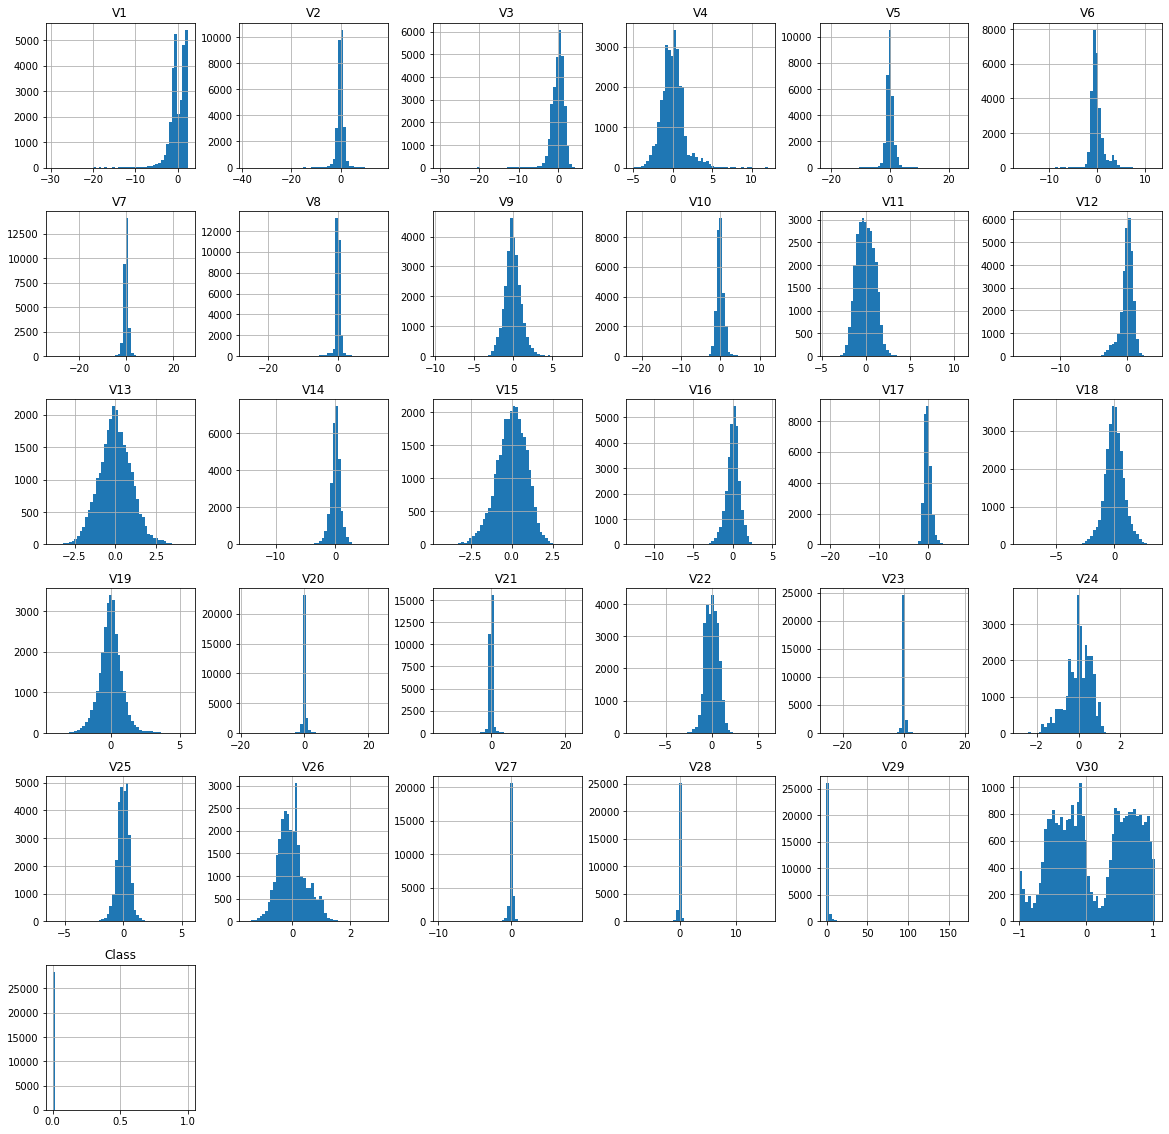

In [5]:
val.iloc[:,1:].hist(bins = 50, figsize = (20,20))
plt.show()

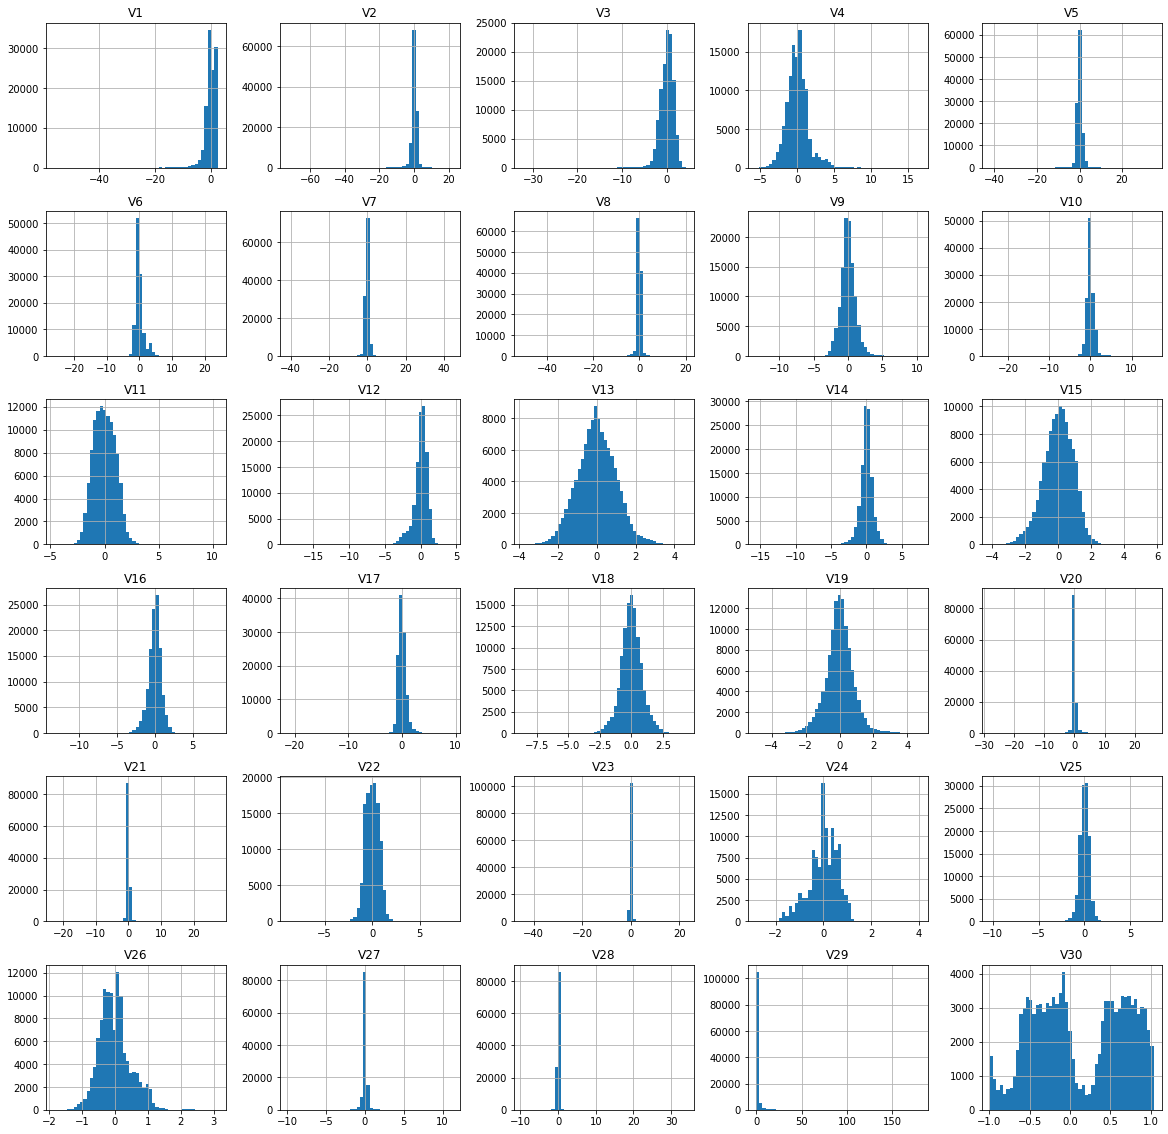

In [6]:
train.iloc[:,1:].hist(bins = 50, figsize = (20,20))
plt.show()

In [23]:
# train.V30.hist(bins = 500)
# if sign(x) = -1 then + 1 else 0

train['V30'] = train.V30.apply(lambda x: x + 1 if np.sign(x) == -1 else x)
test['V30'] = test.V30.apply(lambda x: x + 1 if np.sign(x) == -1 else x)
val['V30'] = val.V30.apply(lambda x: x + 1 if np.sign(x) == -1 else x)

In [24]:
X = val.iloc[:,1:31]
y = val['Class']
df = train.drop(['ID'], axis = 1).sample(X.shape[0], random_state = 42)

In [25]:
print(X.shape)
print(y.shape)

(28462, 30)
(28462,)


I am assuming V30 is time-related value

In [27]:
classifiers = {
                "ISOLATION FOREST": IsolationForest(n_estimators = 255, max_samples = len(X), contamination=.00194, random_state=9001, verbose = 0),
                "LOCAL OUTLIER FACTOR": LocalOutlierFactor(n_neighbors = 200, algorithm='auto', leaf_size=230, metric='euclidean', p = 1, metric_params=None, contamination = .0021),
                "ONE CLASS SVM":OneClassSVM(kernel = 'rbf', degree = 3, gamma = 'auto', nu = 0.00215, max_iter = -1)
              }

In [28]:
for i, (clf_name, clf) in enumerate(classifiers.items()):

    #Fit the data and tag outliers
    if clf_name == "LOCAL OUTLIER FACTOR":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_

    elif clf_name == "ONE CLASS SVM":
        clf.fit(X)
        y_pred = clf.predict(X)

    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    
    # Run Classification Metrics
    print("{} number of errors: {}".format(clf_name, n_errors))
    print(pd.crosstab(y, y_pred)) 
    print('silhouette coefficient:',round(metrics.silhouette_score(df, y_pred, metric='euclidean'), 3))
    print('Adjusted Rand index   :',round(metrics.adjusted_rand_score(y, y_pred),3))
    print("Classification Report :") 
    print(classification_report(y,y_pred))

ISOLATION FOREST number of errors: 54
col_0      0   1
Class           
0      28392  40
1         14  16
silhouette coefficient: 0.087
Adjusted Rand index   : 0.371
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.29      0.53      0.37        30

    accuracy                           1.00     28462
   macro avg       0.64      0.77      0.69     28462
weighted avg       1.00      1.00      1.00     28462

LOCAL OUTLIER FACTOR number of errors: 52
col_0      0   1
Class           
0      28391  41
1         11  19
silhouette coefficient: 0.128
Adjusted Rand index   : 0.421
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.32      0.63      0.42        30

    accuracy                           1.00     28462
   macro avg       0.66      0.82      0.71     28462
weighted avg     

In [29]:
pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 13.8 MB/s 
  Created wheel for pyod: filename=pyod-1.0.3-py3-none-any.whl size=154726 sha256=5f8dfe1315fb17f0b7df88f6deefbb87a500fecb83e9f78de696628619d65d20
  Stored in directory: /root/.cache/pip/wheels/60/1e/04/b42e786399bd7503af674d1ec95d93665b1700309ec3525b65
Successfully built pyod


In [30]:
from pyod.models.auto_encoder import AutoEncoder
from sklearn.decomposition import PCA

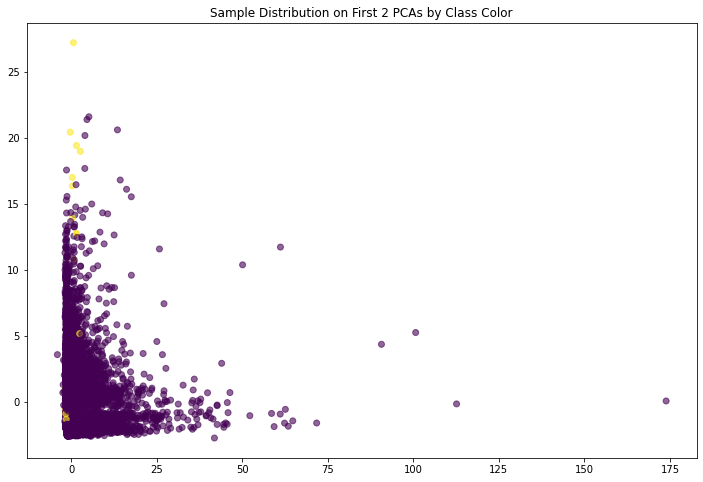

In [31]:
pca = PCA(2)
x_pca = pca.fit_transform(X)
x_pca = pd.DataFrame(x_pca)
x_pca.columns = ['pc1', 'pc2']

plt.figure(figsize=(12,8))
plt.title('Sample Distribution on First 2 PCAs by Class Color')
plt.scatter(x_pca['pc1'], x_pca['pc2'], alpha = .6, c=y)
plt.show()

In [32]:
clf1 = AutoEncoder(hidden_neurons =[15, 10, 6, 2, 2, 6, 10, 15], epochs = 26, contamination = .002)
clf1.fit(X)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 15)                465       
                                                                 
 dropout_2 (Dropout)         (None, 15)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                1

AutoEncoder(batch_size=32, contamination=0.002, dropout_rate=0.2, epochs=26,
      hidden_activation='relu',
      hidden_neurons=[15, 10, 6, 2, 2, 6, 10, 15], l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fbf047e6680>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [33]:
y_scores = clf1.decision_scores_
y_scores = clf1.decision_function(X)  #map all points to one a line
y_scores = pd.Series(y_scores)

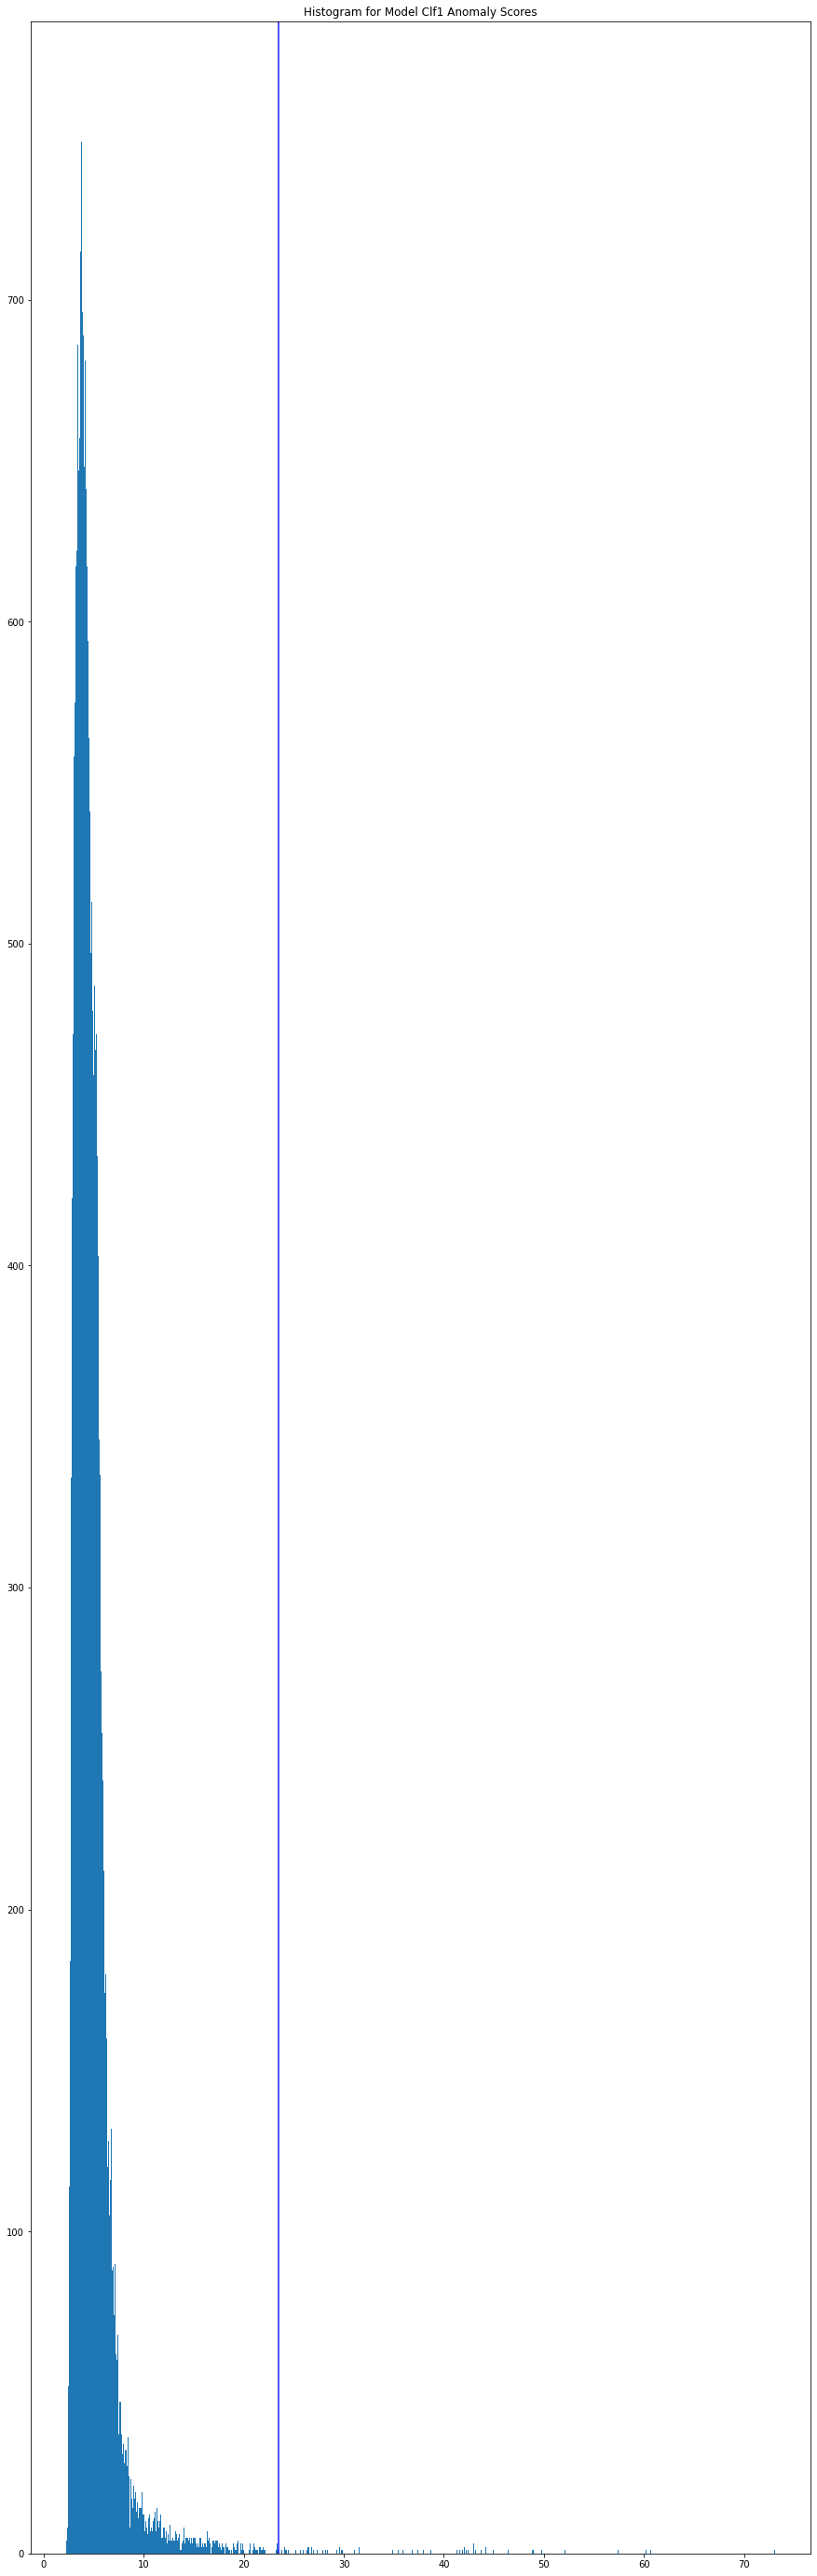

In [34]:
plt.figure(figsize=(15,50))
plt.axvline(23.5, color = 'b', alpha = .9)
plt.hist(y_scores, bins=1000)  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [42]:
x_pca['clf1_score'] = y_scores
x_pca['cluster'] = np.where(x_pca['clf1_score'] < 22.5, 0, 1)
x_pca['cluster'].value_counts()

0    28377
1       85
Name: cluster, dtype: int64

In [36]:
Class = y.reset_index()
Class = Class.drop('index', axis =1)
x_pca['Class'] = Class

In [37]:
n_errors = (x_pca.cluster != x_pca.Class).sum()
print("AutoEncoder number of errors: {}".format(n_errors))
print(pd.crosstab(x_pca.Class, x_pca.cluster))
print('silhouette coefficient:',round(metrics.silhouette_score(x_pca, x_pca.cluster, metric='euclidean'), 3))
print('Adjusted Rand index   :',round(metrics.adjusted_rand_score(x_pca.Class, x_pca.cluster),3))
print("Classification Report :")
print(classification_report(x_pca.Class, x_pca.cluster))

AutoEncoder number of errors: 82
cluster      0   1
Class             
0        28367  65
1           17  13
silhouette coefficient: 0.905
Adjusted Rand index   : 0.239
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.17      0.43      0.24        30

    accuracy                           1.00     28462
   macro avg       0.58      0.72      0.62     28462
weighted avg       1.00      1.00      1.00     28462



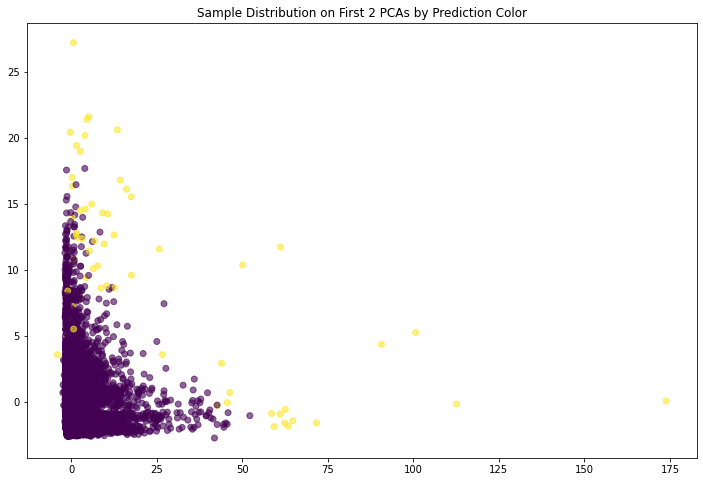

In [38]:
plt.figure(figsize=(12,8))
plt.title('Sample Distribution on First 2 PCAs by Prediction Color')
plt.scatter(x_pca['pc1'], x_pca['pc2'], alpha = .6, c=x_pca['cluster'])
plt.show()